<a href="https://colab.research.google.com/github/WIVIV/Project_3_AFI/blob/master/Proj_3_WF_GRID_TL_with_tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml h5py 

In [0]:
#Mount your Google Drive on your runtime using an authorization code.
#Note this only supports reading, writing, and moving files; to programmatically modify sharing settings or other metadata, use one of the other options below.
#instructions here https://colab.research.google.com/notebooks/io.ipynb#

#from google.colab import drive, files
#drive.mount('/content/gdrive')

**Use TensorFlow V2.x**

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.models import Sequential

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

Test GPU available

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import images from DropBox

In [0]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"


--2020-02-15 16:34:34--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2020-02-15 16:34:35--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc93895b8342674368820edafeb3.dl.dropboxusercontent.com/cd/0/inline/AyLCUsXyiMzK0M1L3pJpNOXRFlsn7pLKP4yRqI20SrsT38YNiuFjSX5FJ9vAecwULAzCpuRe1M80j5VmB4XIIz7grd-fo1FpKZlumXEZOLf4vV9Ww1-KlUEeYB8OT4c0wZA/file# [following]
--2020-02-15 16:34:35--  https://uc93895b8342674368820edafeb3.dl.dropboxusercontent.com/cd/0/inline/AyLCUsXyiMzK0M1L3pJpNOXRFlsn7pLKP4yRqI20SrsT38YNiuFjSX5FJ9vAecwULAzCpuRe1M80j5VmB4XIIz7grd-fo1FpKZlumX

Inspect Image Archive File

In [0]:
!tar -xvf 'grid_version.tar'

Streaming output truncated to the last 5000 lines.
grid_version/train/grid_no_smoke/1498418433_+02040_06_05.png
grid_version/train/grid_no_smoke/1498418373_+01980_08_09.png
grid_version/train/grid_no_smoke/1498418493_+02100_05_06.png
grid_version/train/grid_no_smoke/1498417893_+01500_02_06.png
grid_version/train/grid_no_smoke/1498418253_+01860_04_07.png
grid_version/train/grid_no_smoke/1498418013_+01620_09_06.png
grid_version/train/grid_no_smoke/1498416993_+00600_04_08.png
grid_version/train/grid_no_smoke/1498416993_+00600_03_01.png
grid_version/train/grid_no_smoke/1498417233_+00840_02_01.png
grid_version/train/grid_no_smoke/1498416693_+00300_08_07.png
grid_version/train/grid_no_smoke/1498416693_+00300_06_02.png
grid_version/train/grid_no_smoke/1498418013_+01620_07_03.png
grid_version/train/grid_no_smoke/1498418373_+01980_01_05.png
grid_version/train/grid_no_smoke/1498417533_+01140_03_05.png
grid_version/train/grid_no_smoke/1498416753_+00360_03_04.png
grid_version/train/grid_no_smoke/1

Split data into train and vaildate

In [0]:
train_image_folder ='grid_version/train'
validate_image_folder = 'grid_version/validate'

In [0]:
train_smoke_dir = 'grid_version/train/grid_smoke'  # directory with our training smoke pictures
train_nosmoke_dir = 'grid_version/train/grid_no_smoke'  # directory with our training no smoke pictures
validation_smoke_dir = 'grid_version/validate/grid_smoke' # directory with our validation smoke pictures
validation_nosmoke_dir = 'grid_version/validate/grid_no_smoke' # directory with our validation no smoke pictures


NUmber of images in each subset

In [0]:
num_smoke_tr = len(os.listdir(train_smoke_dir))
num_nosmoke_tr = len(os.listdir(train_nosmoke_dir))

num_smoke_val = len(os.listdir(validation_smoke_dir))
num_nosmoke_val = len(os.listdir(validation_nosmoke_dir))

total_train = num_smoke_tr + num_nosmoke_tr
total_val = num_smoke_val + num_nosmoke_val

In [0]:
print('Total Training Smoke Images:', num_smoke_tr)
print('Total Training No Smoke Images:', num_nosmoke_tr)

print('Total Validation Smoke Images:', num_smoke_val)
print('Total Validation No Somke Images:', num_nosmoke_val)
print("--")
print("Total Training Images:", total_train)
print("'Total Validation Images:", total_val)

Distribution = {
'Total Training Images': total_train,
'Total Validation Images': total_val,
'Total Training Smoke Images': num_smoke_tr,
'Total Training No Smoke Images': num_nosmoke_tr,
'Total Validation Smoke Images': num_smoke_val,
'Total Validation No Somke Images': num_nosmoke_val
}

Total Training Smoke Images: 999
Total Training No Smoke Images: 2622
Total Validation Smoke Images: 999
Total Validation No Somke Images: 2622
--
Total Training Images: 3621
'Total Validation Images: 3621


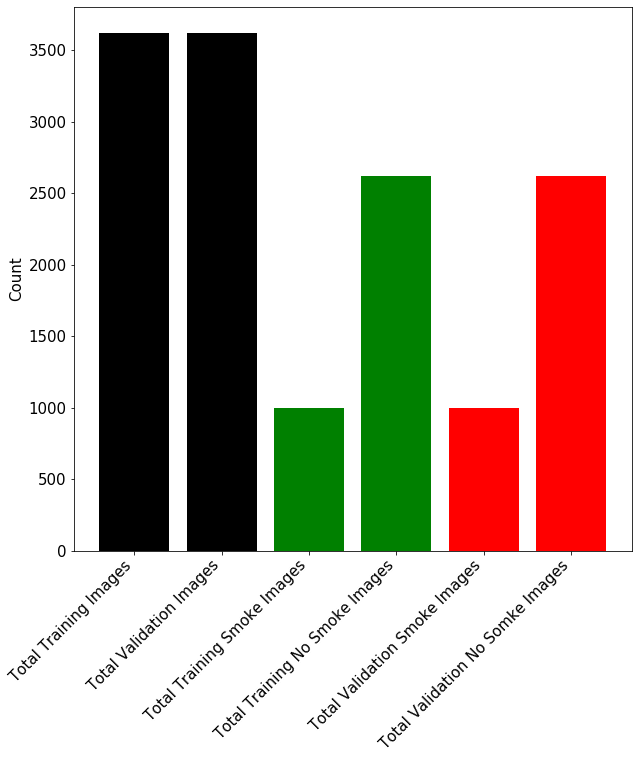

In [0]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(Distribution)), list(Distribution.values()), align='center',color=['black', 'black', 'green', 'green', 'red','red'])
plt.ylabel('Count', fontsize=15)
plt.tick_params(axis="y", labelsize=15)
plt.xticks(range(len(Distribution)), list(Distribution.keys()),rotation=45,ha="right")
plt.tick_params(axis="x", labelsize=15)
plt.show()
#plt.savefig("fig_distribution.png")
#files.download("fig_distribution.png") 

**Create data generator**

In [0]:
#Augment the images. Note best results were gained with limited preprocessing
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            ##Have tried different combintions and values of these settings
                                            #rotation_range=40,
                                            #width_shift_range=0.2,
                                            #height_shift_range=0.2,
                                            #brightness_range=[0.3,-2],
                                            #shear_range=0.2,
                                            #zoom_range=0.2,
                                            #horizontal_flip=True,
                                            #fill_mode='nearest')
)
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Set Paramaters

In [0]:
batch_size = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_mode='binary'


Create train and validate data generators

In [0]:
#using Keras ImageDataGenerator to perform image augmentation and flow_from_directory to take the path to the directory & generates batches of augmented data.
train_data_gen = train_image_generator.flow_from_directory(train_image_folder,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode)

Found 3621 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(validate_image_folder,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode)

Found 3621 images belonging to 2 classes.


Print sample images

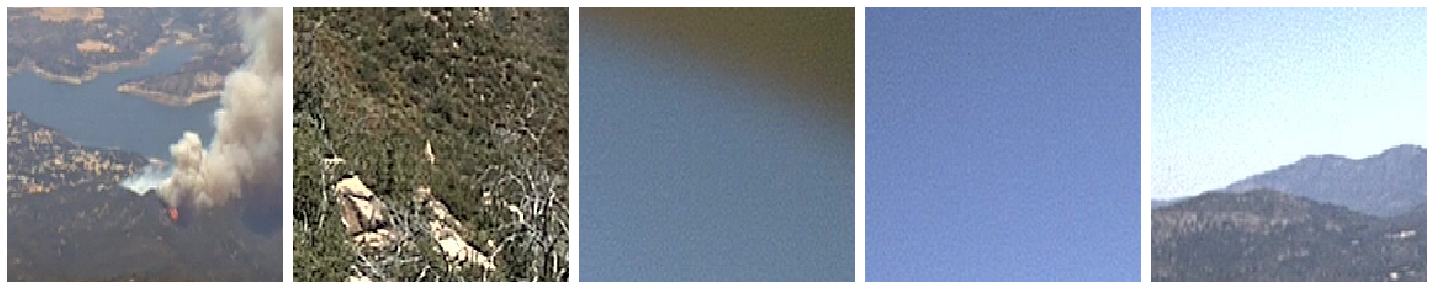

In [0]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
plotImages(sample_training_images[:5])

Create Custom Built Model

In [0]:
#3 conv layers with relu activation and binary crossentropy for loss.
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.optimizers import RMSprop, Adam
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43264)            

Create logs for TensorBoard

In [0]:
log_dir1="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)

In [0]:
#Setting 15 epochs for customer model and then adding epocs for transfer learning and fine turning to allow for data to captured for the complete set and plot the resutls to compare. 
initial_epochs = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=initial_epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    verbose=1,
    callbacks=[tensorboard_callback1]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 1/15
120/120 [==============================] - 22s 187ms/step - loss: 0.3956 - accuracy: 0.8516 - val_loss: 0.4712 - val_accuracy: 0.8203
Epoch 2/15
120/120 [==============================] - 22s 182ms/step - loss: 0.2727 - accuracy: 0.9062 - val_loss: 0.4398 - val_accuracy: 0.7825
Epoch 3/15
120/120 [==============================] - 22s 181ms/step - loss: 0.2021 - accuracy: 0.9440 - val_loss: 0.0992 - val_accuracy: 0.9664
Epoch 4/15
120/120 [==============================] - 21s 178ms/step - loss: 0.1601 - accuracy: 0.9543 - val_loss: 0.0676 - val_accuracy: 0.9764
Epoch 5/15
120/120 [==============================] - 22s 180ms/step - loss: 0.1044 - accuracy: 0.9652 - val_loss: 0.0895 - val_accuracy: 0.9708
Epoch 6/15
120/120 [==============================] - 22s 182ms/step - loss: 0.0925 - accuracy: 0.9655 - val_loss: 0.0401 - val_accuracy: 0.9953
Epoch 7/15
120/120 [================

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Plot results

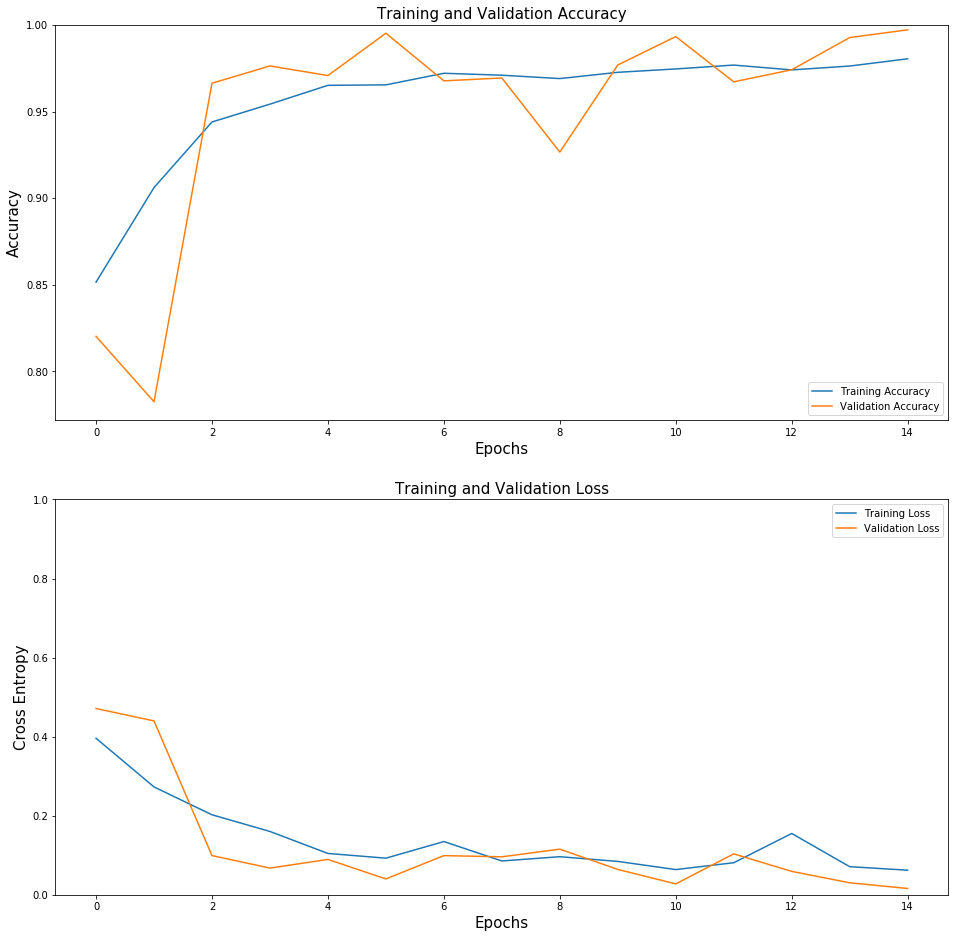

In [0]:
fig_base_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontsize=15)
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epochs',fontsize=15)
plt.title('Training and Validation Accuracy',fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy',fontsize=15)
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
fig_base_model.show()
#plt.savefig("fig_base_model.png")
#files.download("fig_base_model.png") 


In [0]:
#save model to google dirve
#model_save_name = 'custom_model.h5'
#path = F"/content/gdrive/My Drive/{model_save_name}" 
#model.save(path)

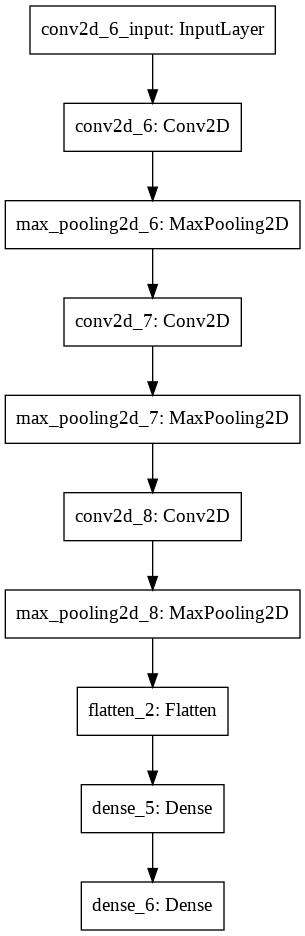

In [0]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [0]:
%tensorboard --logdir logs/fit1/

**Transfer Learning**

In [0]:
#Tranfser Learning using models that are composed of two parts, a convolutional base and a classifier.
#using VGG19 model with imagenet weights
from keras.applications import VGG19

#create a base model using VGG19 with imagenet weights and without the predicitve layer
base_model = tf.keras.applications.VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH,3), include_top=False,weights='imagenet')

In [0]:
batch_size=30
class_mode = 'binary'
total_classes = 1
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'


#Augment the images. Note best results were gained with limited preprocessing
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0,
            #shear_range=0.2, 
            #zoom_range=[0.9, 1.25],
            #brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            vertical_flip=True
            )

#using Keras ImageDataGenerator to perform image augmentation and flow_from_directory to take the path to the directory & generates batches of augmented data.     
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0)


train_generator = train_image_generator.flow_from_directory(
            train_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)

validation_generator = validation_image_generator.flow_from_directory(
            validate_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)




Found 3621 images belonging to 2 classes.
Found 3621 images belonging to 2 classes.


In [0]:
#combining VGG19 with pooling layer and predictio layer
reload_checkpoint=True
img_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(total_classes, activation=activation_function)

#only head weights will be updated:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  #add fully connected layers
  global_average_layer,
  prediction_layer
])


print("Number of layers in the base model: ", len(base_model.layers))
# loop over the layers in the model and show which ones are trainable or not
for layer in model.layers:
	print("{}: {}".format(layer, layer.trainable))

model.compile(optimizer=Adam(lr=0.0005),
              loss=loss_function,
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
<tensorflow.python.keras.engine.training.Model object at 0x7f50f55c6ef0>: False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f50f3cae160>: True
<tensorflow.python.keras.layers.core.Dense object at 0x7f50f3caef60>: True
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


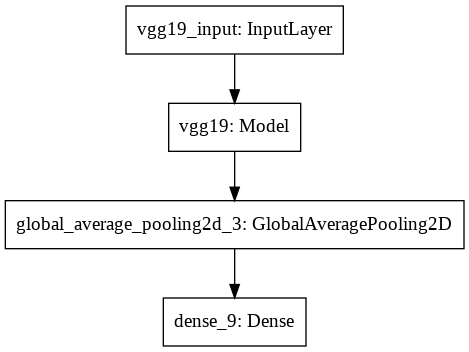

In [0]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [0]:
log_dir2="logs/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [0]:
#run TL for 15 epochs
tl_epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history_tl = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback2],
      epochs=tl_epochs,
      #initial_epoch=history.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 1/15
120/120 [==============================] - 53s 442ms/step - loss: 0.5504 - accuracy: 0.7251 - val_loss: 0.5188 - val_accuracy: 0.7242
Epoch 2/15
120/120 [==============================] - 53s 438ms/step - loss: 0.5009 - accuracy: 0.7249 - val_loss: 0.4812 - val_accuracy: 0.7242
Epoch 3/15
120/120 [==============================] - 53s 438ms/step - loss: 0.4697 - accuracy: 0.7249 - val_loss: 0.4554 - val_accuracy: 0.7303
Epoch 4/15
120/120 [==============================] - 52s 437ms/step - loss: 0.4475 - accuracy: 0.7313 - val_loss: 0.4350 - val_accuracy: 0.7433
Epoch 5/15
120/120 [==============================] - 52s 437ms/step - loss: 0.4268 - accuracy: 0.7625 - val_loss: 0.4179 - val_accuracy: 0.8094
Epoch 6/15
120/120 [==============================] - 52s 437ms/step - loss: 0.4098 - accuracy: 0.7903 - val_loss: 0.4018 - val_accuracy: 0.8269
Epoch 7/15
120/120 [================

In [0]:
#add results from TL model to prior results
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

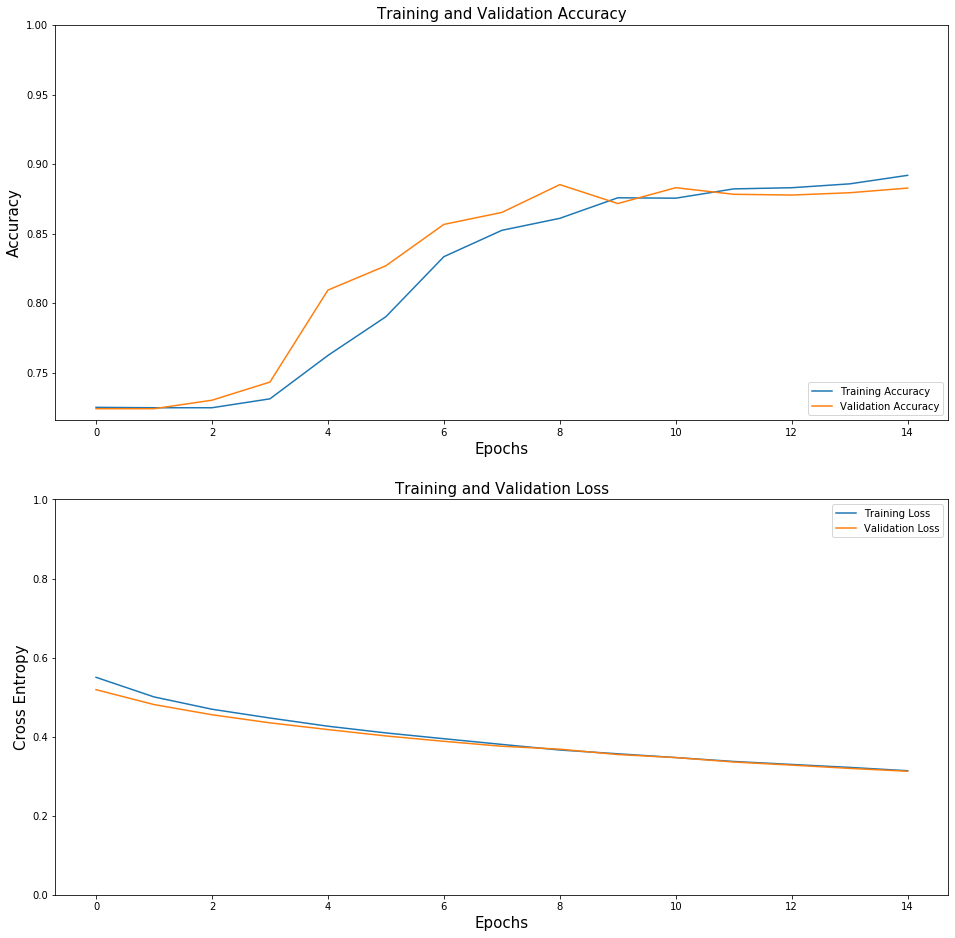

In [0]:
#plot results with line denoting the spilt between models
fig_tl_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.ylabel('Accuracy',fontsize=15)
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='lower right')
plt.xlabel('Epochs',fontsize=15)
plt.title('Training and Validation Accuracy',fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
#plt.plot([initial_epochs,initial_epochs],
#         plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Cross Entropy',fontsize=15)
fig_tl_model.show()
#plt.savefig("fig_tl_model.png")
#files.download("fig_tl_model.png") 

In [0]:
#model.save('tl_model.h5')
#files.download('tl_model.h5')

In [0]:
%tensorboard --logdir logs/fit2/

**Fine Tuning**

In [0]:
#Fine-tune a subset of top layers
#Unlock base model layers
base_model.trainable = True

#reset data generators
train_generator.reset()
validation_generator.reset()

# Fine tune start from layer 19
fine_tune_at = 19

# Freeze layers before fine tuning layer
for layer in base_model.layers[:fine_tune_at]:
     layer.trainable = False

#lower the learning rate
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


print("Number of layers in the base model: ", len(base_model.layers))

# loop over the layers in the model and show which ones are trainableor not
for layer in base_model.layers:
	print("{}: {}".format(layer, layer.trainable))
 
model.summary()


Number of layers in the base model:  22
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f50f54150f0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f54755f8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f5461c88>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50f53e9898>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3f91240>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3b9f7f0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50f3f93c88>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3f93e80>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3b860f0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3bf5eb8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50f3c48550>: False
<tensorflow.

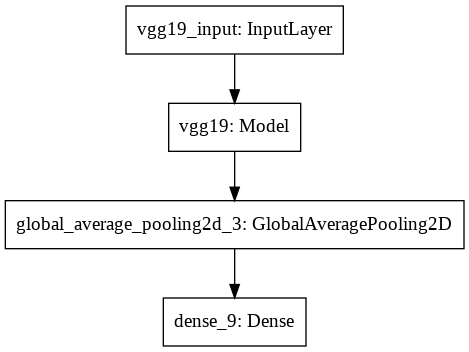

In [0]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [0]:
log_dir3="logs/fit3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)

In [0]:
fine_tune_epochs = 15
total_epochs = tl_epochs + fine_tune_epochs

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback3],
      epochs=total_epochs,
      initial_epoch=history_tl.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 15/30
120/120 [==============================] - 55s 459ms/step - loss: 0.1259 - accuracy: 0.9549 - val_loss: 0.0826 - val_accuracy: 0.9769
Epoch 16/30
120/120 [==============================] - 54s 452ms/step - loss: 0.0744 - accuracy: 0.9761 - val_loss: 0.0535 - val_accuracy: 0.9817
Epoch 17/30
120/120 [==============================] - 54s 451ms/step - loss: 0.0572 - accuracy: 0.9805 - val_loss: 0.0394 - val_accuracy: 0.9842
Epoch 18/30
120/120 [==============================] - 54s 452ms/step - loss: 0.0522 - accuracy: 0.9833 - val_loss: 0.0405 - val_accuracy: 0.9850
Epoch 19/30
120/120 [==============================] - 54s 451ms/step - loss: 0.0470 - accuracy: 0.9841 - val_loss: 0.0723 - val_accuracy: 0.9814
Epoch 20/30
120/120 [==============================] - 54s 452ms/step - loss: 0.0411 - accuracy: 0.9861 - val_loss: 0.0281 - val_accuracy: 0.9850
Epoch 21/30
120/120 [=========

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

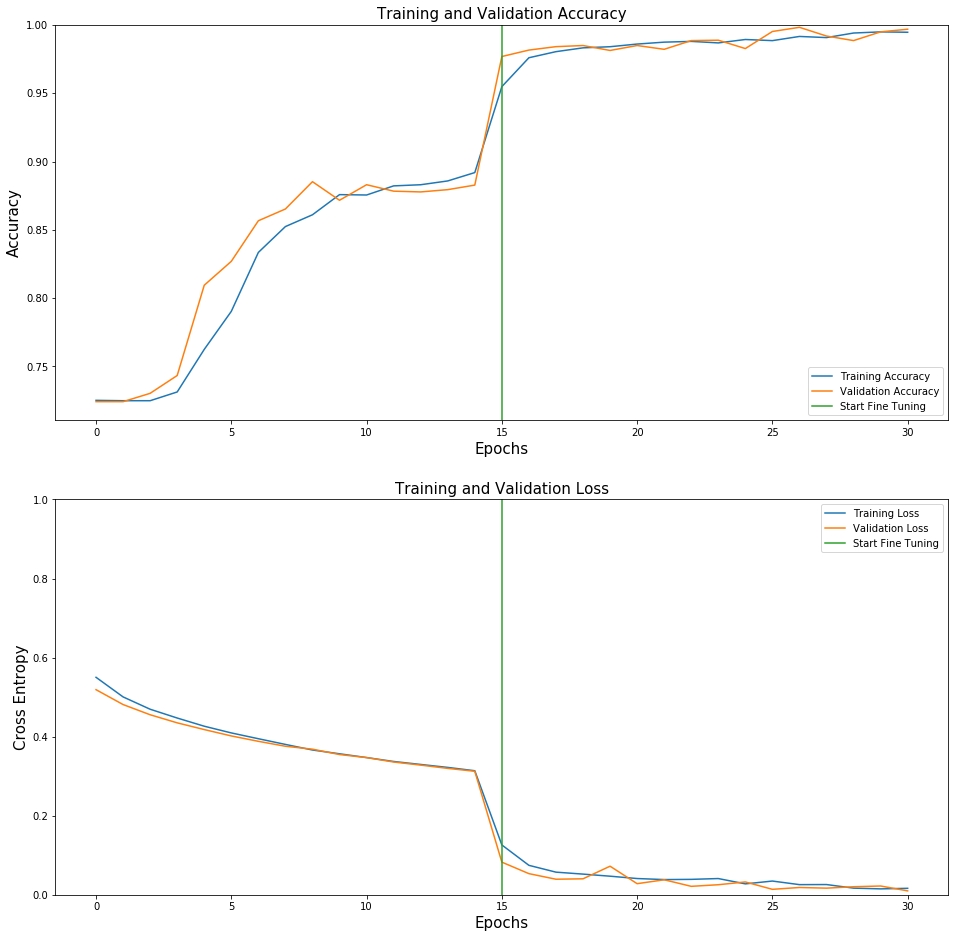

In [0]:
fig_ft_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.ylabel('Accuracy',fontsize=15)
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.plot([tl_epochs,tl_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlabel('Epochs',fontsize=15)
plt.title('Training and Validation Accuracy',fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.plot([tl_epochs,tl_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontsize=15)
plt.ylabel('Cross Entropy',fontsize=15)
plt.xlabel('Epochs',fontsize=15)
fig_ft_model.show()
#plt.savefig("fig_ft_model.png")
#files.download("fig_ft_model.png") 

In [0]:
#save model to google dirve
#ft_model_save_name = 'ft_model.h5'
#path = F"/content/gdrive/My Drive/{ft_model_save_name}" 
#model.save(path)

In [0]:
%tensorboard --logdir logs/fit3/

BREAK